**Part 1: Linear regression using only the numerical data**

In the part 0 we did some basic prepossing. We saw that there were 34 numerical features, and 45 categorical, for a total of 79 features. In this part we perform a linear regression using only the 34 numerical features. We begin by reproducing the basic data preprocessing in part 0, ignoring the normalisation step that theoretically has no effect for linear regression. We also clean up the code a little, removing the unnecessary parts.

**Step 1: Reproduce steps 1-4 of part 0**

In [1]:
import pandas as pd
import numpy as np

# Import train and test data, save train SalePrice and test Id separately, remove train SalePrice and train and test Id
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
train.drop(['Id'], axis=1, inplace=True)
submission = test[['Id']]
test.drop(['Id'], axis=1, inplace=True)
train_sale_price = train[['SalePrice']]
train.drop(['SalePrice'], axis=1, inplace=True)

# Split features/columns into numerical and categorical lists
numeric_features_columns = list(train.select_dtypes(include=[np.number]).columns)
categorical_features_list_to_remove_from_numerical = ['MSSubClass', 'MoSold']
numeric_features_columns = list(set(numeric_features_columns) - set(categorical_features_list_to_remove_from_numerical))
train['MSSubClass'] = train['MSSubClass'].apply(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)
train['MoSold'] = train['MoSold'].apply(str)
test['MoSold'] = test['MoSold'].apply(str)
categorical_features_columns = list(set(train.columns) - set(numeric_features_columns))

# Fill in the missing data
latest_year_house_sold = train['YrSold'].max()
train['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
test['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
train_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if train[feature].isnull().sum() > 0]
test_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if test[feature].isnull().sum() > 0]
train_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if train[feature].isnull().sum() > 0]
test_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if test[feature].isnull().sum() > 0]

for feature in train_numeric_features_with_missing_values:
    train[feature].fillna(0, inplace = True)

for feature in test_numeric_features_with_missing_values:
    test[feature].fillna(0, inplace = True)

categoric_features_with_NA = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'Fence',
    'FireplaceQu',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'GarageType',
    'MiscFeature',
    'PoolQC'
]
for feature in train_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        train[feature].fillna('NA', inplace = True)
    else:
        train[feature].fillna(train[feature].value_counts().idxmax(), inplace = True)
        
for feature in test_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        test[feature].fillna('NA', inplace = True)
    else:
        test[feature].fillna(test[feature].value_counts().idxmax(), inplace = True)

# Convert year features to age features
year_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
train['AgeOfHouse'] = train['YrSold'] - train['YearBuilt']
train['AgeOfRemodAdd'] = train['YrSold'] - train['YearRemodAdd']
train['AgeOfGarage'] = train['YrSold'] - train['GarageYrBlt']
train['AgeOfSale'] = latest_year_house_sold - train['YrSold']
test['AgeOfHouse'] = test['YrSold'] - test['YearBuilt']
test['AgeOfRemodAdd'] = test['YrSold'] - test['YearRemodAdd']
test['AgeOfGarage'] = test['YrSold'] - test['GarageYrBlt']
test['AgeOfSale'] = latest_year_house_sold - test['YrSold']
age_features = ['AgeOfHouse', 'AgeOfRemodAdd', 'AgeOfGarage', 'AgeOfSale']
train.drop(year_features, axis=1, inplace=True)
test.drop(year_features, axis=1, inplace=True)
numeric_features_columns = list(set(numeric_features_columns) - set(year_features))
numeric_features_columns = list(set(numeric_features_columns).union(set(age_features)))

# Log transformation of train SalePrice
train_sale_price['SalePrice'] = train_sale_price['SalePrice'].apply(np.log)

print(len(numeric_features_columns))
print(len(categorical_features_columns))

34
45


/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


There are 34 numerical features and 45 categorical features.

**Step 2: Linear regression using only the numeric features**

We now make our first set of predictions: Linear regression using only the 34 numeric train features.

In [2]:
X = train[numeric_features_columns] # The numerical train features
Y = train_sale_price.copy() # The train salePrices
print(X.shape)
print(Y.shape)

(1460, 34)
(1460, 1)


We use the linear regression model from sklearn which finds the 'best linear fit' of X to Y. Without going into too much detail, it constructs Y' which depends linearly on the features in X, and which minimises the sum of squares between Y and Y'. Again, without going into too much detail, there is an unique mathematical solution for Y' if the columns of the matrix X are linearly independent. We will return to this point when we discuss correlations in X in a later improved prediction.

Before making the final prediction we wish to test the accuracy of the linear regression on some train subsets.

In [3]:
from sklearn.model_selection import train_test_split # Library to split the train data into train-test subsets

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=.33) # x_train and y_train are corresponding subsets X and Y of size .67 compared to X and Y. x_test and y_test are the remaining subsets of X and Y of size .33.

We will train a linear regression model using x_train and y_train. We will then apply the trained model to x_test to predict the values in y_test. More exactly, we score our predictions by calculating the RMSE of between our predictions and y_test. Recall that values in Y were the log transformed sale prices. Therefore y_test contains the actual log transformed sale prices, we will predict these log transformed sale prices. The RMSE between the two is how kaggle scores actual submissions, and so is a great metric to check. 

First we save the actual log transformed sale prices in a new dataframe.

In [4]:
actual_log_prices = y_test

print(actual_log_prices.shape)
actual_log_prices.head()

(482, 1)


,SalePrice
892,11.947949
1105,12.691580
413,11.652687
522,11.976659
1036,12.661914


Next we perform linear regression on the train-test split and make predictions.

In [5]:
from sklearn import linear_model # Import the linear model

lr = linear_model.LinearRegression() # Initialise the linear model
model = lr.fit(x_train, y_train) # Calculate the best linear fit Y' of x_train to y_train
predicted_log_prices = model.predict(x_test) # Use Y' and x_test to predict the values of y_test. This returns an array
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice']) # Convert the array to a dataframe

print(predicted_log_prices.shape)
predicted_log_prices.head()

(482, 1)


,SalePrice
0,11.927564
1,12.617076
2,11.661684
3,12.025795
4,12.612827


Finally we calculate the RMSE between the two to score our prediction, and make a scatter plot to visualise our prediction.

0.1519846334701592


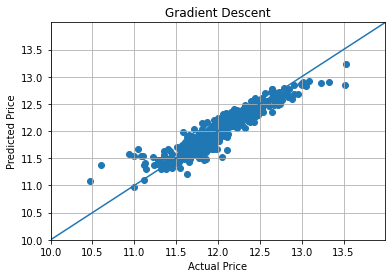

In [8]:
from sklearn.metrics import mean_squared_error # The square root of this is the RMSE
from matplotlib import pyplot as plt # For visualising our predictions on some train subsets

print(np.sqrt(mean_squared_error(predicted_log_prices, actual_log_prices))) # RMSE between the actual and predicted log transformed sale prices

# Scatter plot between the actual and predicted log transformed sale prices between 10 and 14 in both axes.
fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('Linear Regression')
plt.show() 

A reasonable result!! Now we are ready for our first submission to kaggle. We do not split X and Y and calculate the linear regression using the whole spaces.

In [9]:
model = lr.fit(X, Y) # Calculate the best linear fit Y' of X to Y
X_test = test[numeric_features_columns] # The numeric test data, which we will use to predict the sale prices
predicted_log_prices = model.predict(X_test) # Use Y' and X_test to predict the log transformed and normalised sale prices, and convert the result into a dataframe
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice']) # Convert the array to a dataframepredicted_prices

print(predicted_log_prices.shape)
predicted_log_prices.head()

(1459, 1)


,SalePrice
0,11.673165
1,11.850893
2,12.025227
3,12.179488
4,12.149859


Recall that we saved the test Id information earlier in the submission dataframe, which we must combine with our predictions so that we can make a submission to kaggle. Recall also that we predicted the log transformed sale prices, so we must perform an exponential transform (the inverse of the log transform) to predict the actual sale prices. We do both now.

In [10]:
submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp) # exponential transform of predicted log prices
submission

/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Id,SalePrice
0,1461,117379.204707
1,1462,140209.492438
2,1463,166912.800037
3,1464,194753.036569
4,1465,189067.361685
...,...,...
1454,2915,99946.290860
1455,2916,101453.062294
1456,2917,180615.471032
1457,2918,115453.458067


We finally create a file for submission to kaggle.

In [11]:
submission.to_csv('submission.csv',index=False) # Generate a submission file named linear_only_numeric with the correct format for kaggle submission

Submitting this file to kaggle gives a **RMSE score of 0.14890**. This is comparable to the score on our train-test split above. As a reminder, this was obtained from a linear regression on only the numerical features, 34 out of 79 total features. Next we will incorporate categorical features.